# Pronósticos usando Deep Learning

¡Bienvenidos y Bienvenidas! El día de hoy realizaremos una introducción sobre cómo realizar pronósticos utilizando Deep Learning. Particularmente utilizaremos el poder de las Redes Neuronales Recurrentes para generar un modelo capaz de predecir el consumo de energía eléctrica de 370 consumidores en Estados Unidos. Utilizarmeos una muestra del *[UCI Electricity Load Diagrams Dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014)*

Es necesario que instales las librerías que se encuentran en el archivo `requirements.txt` para que puedas seguir junto al resto de la clase. 

# El problema a Resolver


![context](imgs/context.png)

Es un problema de pronóstico para múltiples series con múltiples pasos (un horizonte de 24 periodos, $h = 24$).

Este tipo de problemas es un claro ejemplo de las ventajas de las Redes Neuronales sobre modelos clásicos, pues con un único modelo es posible realizar predicciones para cada "individuo". 

(Una lectura sugerida: [Modelos de Pronóstico de Demanda usando Redes Neuronales](https://medium.com/mercadolibre-tech/global-time-series-forecasting-models-for-item-level-demand-and-sales-forecasts-in-our-marketplace-aee2956957ae)

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
np.random.seed(42)

In [3]:
tf.__version__ # ¡Verifica que tu versión de TensorFlow sea 2.3.1!

'2.3.1'

## Carga de Información

Antes de comenzar, debemos realizar la carga de información. Nuestros datos se encuentran en la ruta `sample/electricity.csv`. Es un CSV que contiene una muestra de la información de consumo de electricidad en USA. 

In [4]:
df = pd.read_csv('sample/electricity.csv')

In [5]:
df = df.sort_values(by = ['categorical_id', 'date'])

In [6]:
df.head()

,power_usage,t,days_from_start,categorical_id,date,id,hour,day,day_of_week,month,hours_from_start,categorical_day_of_week,categorical_hour
0,1.586294,30960.0,1290,MT_001,2014-07-14 00:00:00,MT_001,0,14,0,7,30960.0,0,0
1,1.269036,30961.0,1290,MT_001,2014-07-14 01:00:00,MT_001,1,14,0,7,30961.0,0,1
2,1.269036,30962.0,1290,MT_001,2014-07-14 02:00:00,MT_001,2,14,0,7,30962.0,0,2
3,1.269036,30963.0,1290,MT_001,2014-07-14 03:00:00,MT_001,3,14,0,7,30963.0,0,3
4,1.586294,30964.0,1290,MT_001,2014-07-14 04:00:00,MT_001,4,14,0,7,30964.0,0,4


# Un rápido Análisis Exploratorio

Antes de cualquier etapa de modelamiente es importante realizar un Análisis Exploratorio de los Datos. Los problemas de series de tiempo NO son la excepción. Revisaremos qué tipos de datos tenemos, cómo se comportan y qué problemas pueden generarnos. 

Comenzamos graficando la distribución del uso de energía eléctrica, la cual nos muestra que tenemos algunos valores atípicos, pero que la mayoría de la información se encuentra en uso por debajo de 2500. 

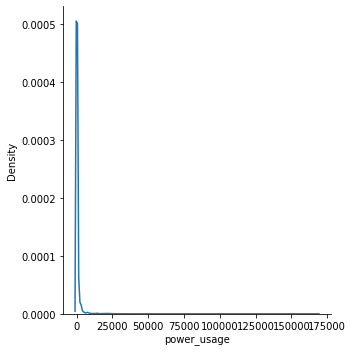

In [7]:
sns.displot(data=df, x="power_usage", kind="kde")

(0.0, 25000.0)

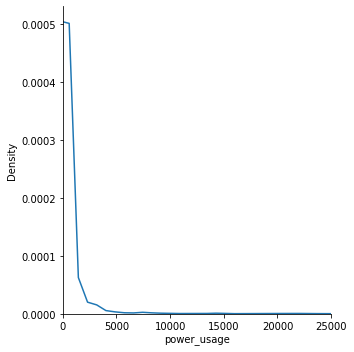

In [8]:
sns.displot(data=df, x="power_usage", kind="kde")
plt.xlim(0, 25000)

Lo anterior podría llegar a ser un problema si se presenta como valores atípicos en las series de tiempo. 

A continuación, realizamos un gráfico de algunas de las series de consumo de electricidad para algunos de los clientes. Estamos en busca de problemas que puedan existir dentro de la información como: 
1. Raíces Unitarias
2. Volatilidad 
3. Quiebres estructurales

Debido a la cantidad de series de clientes que se tienen, no es tan fácil realizar un análisis complejo. Vamos a requerir de soluciones generales. 

In [9]:
def plot_id_info(df, customer_id, variable, n_history = 72, target_length = 24):
    """
    Plots a customer's information for the last week + 24 hours.
    """
    plt.figure(figsize =(10, 5))
    customer_df = df[df.categorical_id == customer_id].copy().sort_values(by='date').tail(n_history)
    customer_df['date'] = pd.to_datetime(customer_df['date'])
    
    plt.plot(customer_df['date'].head(n_history - target_length), customer_df[variable].head(n_history - target_length), label = 'Input', color = 'black')
    plt.plot(customer_df['date'].tail(target_length), customer_df[variable].tail(target_length), label = 'Target', color = 'red')
    plt.legend()

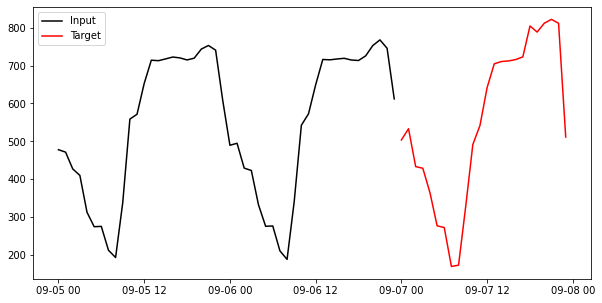

In [10]:
plot_id_info(df, 'MT_353', 'power_usage')

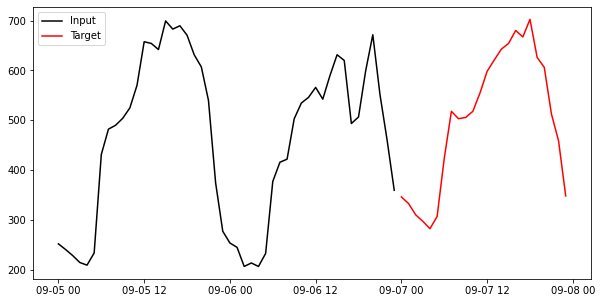

In [11]:
plot_id_info(df, 'MT_178', 'power_usage')

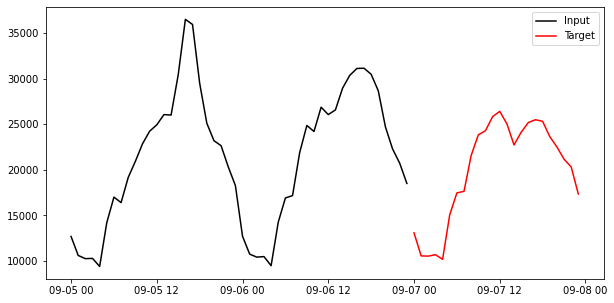

In [12]:
plot_id_info(df, 'MT_196', 'power_usage') # Este es uno de los que tienen consumo mayor a 25000

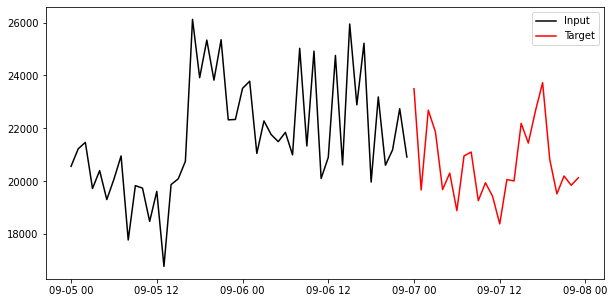

In [13]:
plot_id_info(df, 'MT_370', 'power_usage') # Este es uno de los que tienen consumo mayor a 25000

Se pueden hacer análisis más a profundidad de las series de tiempo, pero por lo pronto nos llevamos que las series no aparentan tener tendencia y presentan ciclos bastante marcados a la hora del día. Posiblemente estos ciclos sean diferentes si se está analizando un fin de semana a un día cualquiera. 

Habiendo hecho este (sencillo) análisis, pasaremos a definir el modelo que se va a entrenar.

# Datos para Entrenamiento

Como nuestro objetivo es hacer un modelo Global para pronosticar el consumo de electricidad, requerimos definir qué metodología se va a utilizar para el modelo. A continuación se describen dos posibles caminos para realizar este pronóstico:

1. **Pronosticar directamente las 24 horas (Single Shot)**
![SingleShot](imgs/RNN.png)
<a><center>Source: https://www.tensorflow.org/tutorials/structured_data/time_series#single-shot_models!</center></a>

2. **Pronosticar una hora a la vez utilizando autoregresivamente las predicciones (feed forecasts)**

![Autoreg](imgs/autoregressive.png)
<a><center>Source: https://www.tensorflow.org/tutorials/structured_data/time_series#advanced_autoregressive_model!</center></a>


Para este ejercicio realizaremos un modelo de Single Shot forecasting.

## Aproximación por Ventanas

Actualmente contamos con series completas para cada uno de los clientes. Es necesario convertir esta información a un formato adecuado para el entrenamiento: ventanas de información. De esta forma, el modelo recibe una ventana de información de cierto tamaño y debe predecir otra ventana de información. 

In [14]:
class processElectricityDataFrame:
    """
    Procesa el DataFrame para generar un data set de ventanas.
    """
    
    def __init__(self, train_df, val_df, test_df, index_variable, target_variable,
                input_window, output_window, step = 24):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df   
        
        self.label_name = target_variable
        self.input_window = input_window
        self.output_window = output_window
        self.index_variable = index_variable
        self.step = step
        
        
        self.model_columns = None # Variables de la ventana
            
    
    def create_npy_dataset(self, df, folder, name, columns, input_window, output_window, label_name):
        """
            df: DataFrame a utilizar
            folder: Folder para almacenar el .npy
            columns: Lista de las columnas que se utilizarán al final
            name: Nombre para el archivo (train, val, test)
            input_window: Tamaño de la ventana de entrada (12)
            output_window: Tramaño de la ventana de salida (12)
            label_name: Nombre de la variable objetivo
        
        """
        file_input = os.path.join(folder, f'input_{name}.npy')
        file_output = os.path.join(folder, f'output_{name}.npy')

        unique_id_names = df[self.index_variable].value_counts().index.values
        npy_input = None
        npy_output = None

        label_index = columns.index(label_name)
        input_columns = columns.copy()
            
        window_size = input_window + output_window
        
        print(f'Started .npy creation with name: {name}')
        for id_name in tqdm(unique_id_names):
            
            customer_df = df[df[self.index_variable] == id_name].sort_values(by = 'date').copy()
            output_tmp_df = customer_df[columns].values
            input_tmp_df = customer_df[input_columns].values
            n_windows = len(output_tmp_df) - window_size + 1
            
            input_array = np.expand_dims(np.arange(self.input_window), 0) +  np.expand_dims(np.arange(n_windows, step = self.step), 0).T
            output_array = np.expand_dims(np.arange(self.output_window), 0) + self.input_window +  np.expand_dims(np.arange(n_windows, step = self.step), 0).T
            
            
            inputs = input_tmp_df[input_array].astype(np.float32)
            labels = output_tmp_df[output_array, label_index].astype(np.float32)
            
            if npy_input is None:
                
                npy_input = inputs
                npy_output = labels
            else:
                
                npy_input = np.append(npy_input, inputs, axis = 0)
                npy_output = np.append(npy_output, labels, axis = 0)
                
                random_index = np.random.choice(npy_input.shape[0], npy_input.shape[0], replace=False)
                
                npy_input = npy_input[random_index, :, :]
                npy_output = npy_output[random_index, :]
                
        

        with open(file_input, 'wb') as f:
            np.save(f, npy_input)

        with open(file_output, 'wb') as f:
            np.save(f, npy_output)

        print('Completed .npy creation.')        

        
    def preprocess_fn(self, df, model_type):      
        if model_type == 'raw_inf':
            df[self.label_name] = np.log(df[self.label_name] + 1)
            self.model_columns = [self.label_name]#, 'hour', 'day_of_week', 'month']
            return df
        

        
    def create_all_datasets(self, folder_name = 'data', model_type = 'raw_inf'):
        
        if not os.path.isdir(folder_name):
            os.mkdir(folder_name)
            
        train_df = self.preprocess_fn(self.train_df, model_type)    
         
        self.create_npy_dataset(df = train_df, folder = folder_name, name = 'train', columns =  self.model_columns,
                               input_window = self.input_window, output_window = self.output_window, label_name = self.label_name)
        
        val_df = self.preprocess_fn(self.val_df, model_type)    
         
        self.create_npy_dataset(df = val_df, folder = folder_name, name = 'val', columns =  self.model_columns,
                               input_window = self.input_window, output_window = self.output_window, label_name = self.label_name)
        
        
        test_df = self.preprocess_fn(self.test_df, model_type)    
         
        self.create_npy_dataset(df = test_df, folder = folder_name, name = 'test', columns =  self.model_columns,
                               input_window = self.input_window, output_window = self.output_window, label_name = self.label_name)

In [15]:
test_df = df[df.date >= '2014-08-31']
val_df = df[(df.date >= '2014-08-24') & (df.date < '2014-08-31')]
train_df = df[df.date < '2014-08-24']


In [16]:
df_process = processElectricityDataFrame(train_df, 
                                         val_df, 
                                         test_df, 
                                         index_variable = 'categorical_id',
                                         target_variable = 'power_usage',
                                         input_window = 48,
                                         output_window = 24, 
                                         step = 3)

In [17]:
df_process.create_all_datasets(folder_name = 'data', model_type = 'raw_inf')

<ipython-input-14-e457fdd8375d>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.label_name] = np.log(df[self.label_name] + 1)


Started .npy creation with name: train


100%|██████████| 369/369 [00:22<00:00, 16.71it/s]


Completed .npy creation.
Started .npy creation with name: val


100%|██████████| 369/369 [00:03<00:00, 98.40it/s] 


Completed .npy creation.
Started .npy creation with name: test


100%|██████████| 369/369 [00:04<00:00, 87.45it/s] 

Completed .npy creation.


In [18]:
train_input_example = np.load('data/input_train.npy')
train_output_example = np.load('data/output_train.npy')

In [19]:
train_input_example.shape

(112513, 48, 1)

In [20]:
train_output_example.shape

(112513, 24)

In [21]:
train_input_example[0, :, :]

array([[4.363695 ],
       [4.531666 ],
       [4.5478997],
       [4.5478997],
       [4.593658 ],
       [4.626646 ],
       [4.654629 ],
       [4.7071447],
       [4.7594037],
       [4.841222 ],
       [4.8455744],
       [4.8056793],
       [4.8090777],
       [4.789739 ],
       [4.7378645],
       [4.652004 ],
       [4.4167805],
       [4.3205686],
       [4.2982593],
       [4.3108177],
       [4.284555 ],
       [4.2806945],
       [4.2366586],
       [4.2486134],
       [4.433306 ],
       [4.582406 ],
       [4.5964546],
       [4.640077 ],
       [4.6664104],
       [4.672893 ],
       [4.6933174],
       [4.708388 ],
       [4.707157 ],
       [4.754658 ],
       [4.8638725],
       [4.8585196],
       [4.8313503],
       [4.798882 ],
       [4.7629623],
       [4.671592 ],
       [4.5030184],
       [4.305739 ],
       [4.292646 ],
       [4.3020153],
       [4.318718 ],
       [4.318718 ],
       [4.2907424],
       [4.2939816]], dtype=float32)

In [22]:
train_output_example[0, :]

array([4.5091324, 4.709642 , 4.6333776, 4.657274 , 4.6983743, 4.665101 ,
       4.7317905, 4.7146173, 4.7071447, 4.7439017, 4.885969 , 4.861743 ,
       4.8258204, 4.8079424, 4.7897277, 4.773517 , 4.636052 , 4.399944 ,
       4.3094854, 4.290214 , 4.314545 , 4.318718 , 4.2850294, 4.2964044],
      dtype=float32)

# Entrenamiento de Modelo

Inicialmente cargamos la información en memoria para proceder a realizar el entrenamiento.

In [23]:
def load_dataset(path_to_features, path_to_labels):
    features = np.load(path_to_features)
    labels = np.load(path_to_labels)
    
    assert features.shape[0] == labels.shape[0]
    dataset = tf.data.Dataset.from_tensor_slices((features, labels)).batch(128)
    return dataset

In [24]:
train_features = os.path.join('data', 'input_train.npy')
train_labels = os.path.join('data', 'output_train.npy')
train_dataset = load_dataset(train_features, train_labels)

val_features = os.path.join('data', 'input_val.npy')
val_labels = os.path.join('data', 'output_val.npy')
val_dataset = load_dataset(val_features, val_labels)

test_features = os.path.join('data', 'input_test.npy')
test_labels = os.path.join('data', 'output_test.npy')
test_dataset = load_dataset(test_features, test_labels)

In [25]:
def validate_inf(arrays):
    for array in arrays:
        loaded_array = np.load(os.path.join(array))
        n_inf = np.isinf(loaded_array).sum()
        if n_inf:
            print(f'Array {array} contains INF values')
            
        n_nan = np.isnan(loaded_array).sum()
        if n_nan:
            print(f'Array {array} contains NAN values')

In [26]:
validate_inf([train_features, train_labels, val_features, val_labels])

In [27]:
np.load(val_labels).max()

12.03232

In [28]:
np.isnan(np.load(val_labels)).sum()

0

Y procedemos a definir el modelo que se va a entrenar. En este caso haremos uso de una red con celdas tipo LSTM. Esta arquitectura es arbitraria, por lo que el usuario debe escoger la ccantidad de capas ocultas, de celdas en cada capa, y el dropout en cada capa. Esto se realizaría mediante la *búsqueda de hiperparámetros*. 

In [29]:
model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'),
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'),
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.LSTM(16, return_sequences=False, activation='relu'),
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.Dense(24),
        ])

Definido el modelo, se ubica la información de dónde se va a guardar los logs de entrenamiento para su posterior análisis.

In [30]:

checkpoint_folder = 'training/'
tf_log_dir = 'training/logs'

if not os.path.exists(checkpoint_folder):
    os.mkdir(checkpoint_folder)
    
if not os.path.exists(tf_log_dir):
    os.mkdir(tf_log_dir)


In [31]:
name = 'class_example'
execution_time = datetime.now().strftime("%Y%m%d-%H%M%S")
tf_log_dir = 'training'
logdir = f"{tf_log_dir}/arbitrary/{name}_{execution_time}" 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

checkpoint_path = f"{checkpoint_folder}/checkpoints_{name}_{execution_time}/cp.ckpt"
checkpoints_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)



Hasta este punto se ha definido dónde guardar y qué guardar. Sin embargo, una buena práctica a la hora de entrenar un modelo es hacer uso del *Early Stopping*. 

In [32]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [33]:
EPOCHS = 200
model.compile(
      optimizer=tf.optimizers.Adam(learning_rate=0.001),
      loss=tf.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

In [34]:
model.fit(train_dataset, 
          validation_data=val_dataset, 
          callbacks=[tensorboard_callback, checkpoints_callback, earlystopping_callback],
          epochs=EPOCHS, 
          verbose=1) 

Epoch 1/200
  1/880 [..............................] - ETA: 0s - loss: 27.1045 - root_mean_squared_error: 5.2062WARNING:tensorflow:From /Users/jcobapuerto/Library/Python/3.8/lib/python/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
879/880 [============================>.] - ETA: 0s - loss: 1.8233 - root_mean_squared_error: 1.3503
Epoch 00001: val_loss improved from inf to 0.24288, saving model to training//checkpoints_class_example_20220511-002739/cp.ckpt
880/880 [==============================] - 64s 73ms/step - loss: 1.8233 - root_mean_squared_error: 1.3503 - val_loss: 0.2429 - val_root_mean_squared_error: 0.4928
Epoch 2/200
879/880 [============================>.] - ETA: 0s - loss: 0.4620 - root_mean_squared_error: 0.6797
Epoch 00002: val_loss improved from 0.24288 to 0.19797, saving model to training//c

In [35]:
model.load_weights(checkpoint_path) # Cargamos Pesos del Mejor Modelo

In [36]:
model.evaluate(test_dataset)

119/119 [==============================] - 2s 20ms/step - loss: 0.0930 - root_mean_squared_error: 0.3050


[0.0930221825838089, 0.30499547719955444]

In [37]:
model.evaluate(val_dataset)

96/96 [==============================] - 2s 20ms/step - loss: 0.0710 - root_mean_squared_error: 0.2665


[0.07102379202842712, 0.26650288701057434]

# Evaluación del Modelo

In [38]:
X = np.load(test_features)
Y = np.load(test_labels)

In [39]:
Y_hat = model.predict(X)

In [40]:
def plot_predictions(Y_past, Y_true, Y_pred, idx_obs, exponent = True):
    plt.figure(figsize = (10, 5))
    input_length = Y_past.shape[1]
    ouput_length = Y_pred.shape[1]
    if not exponent:
        plt.plot(np.arange(input_length), Y_past[idx_obs, :, 0], color = 'black')
        plt.plot(np.arange(input_length, input_length+ouput_length), Y_true[idx_obs,: ], color = 'black', label = 'True Usage', linestyle = '--')
        plt.plot(np.arange(input_length, input_length+ouput_length), Y_pred[idx_obs, :], color = 'red', label = 'Prediction')
    else:
        plt.plot(np.arange(input_length), np.exp(Y_past[idx_obs, :, 0]) - 1, color = 'black')
        plt.plot(np.arange(input_length, input_length+ouput_length), np.exp(Y_true[idx_obs,: ]) - 1, color = 'black', label = 'True Usage', linestyle = '--')
        plt.plot(np.arange(input_length, input_length+ouput_length), np.exp(Y_pred[idx_obs, :]) - 1, color = 'red', label = 'Prediction')
    plt.legend()

Inspeccionaremos visualmente algunas predicciones del modelo

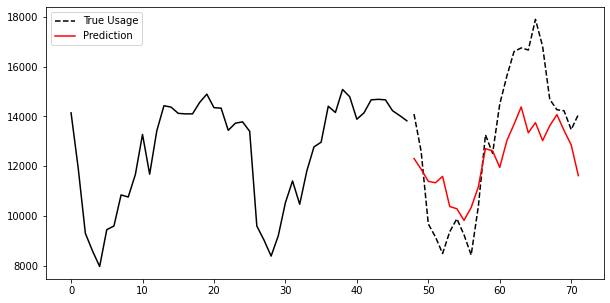

In [41]:
plot_predictions(X, Y, Y_hat, 960)

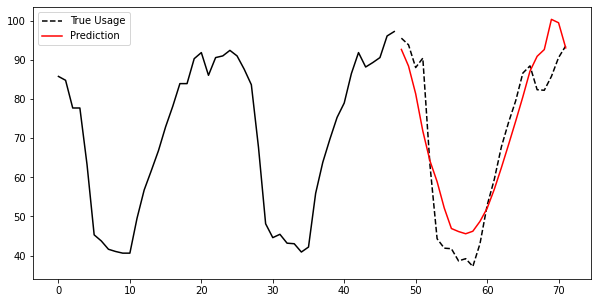

In [42]:
plot_predictions(X, Y, Y_hat, 2099)

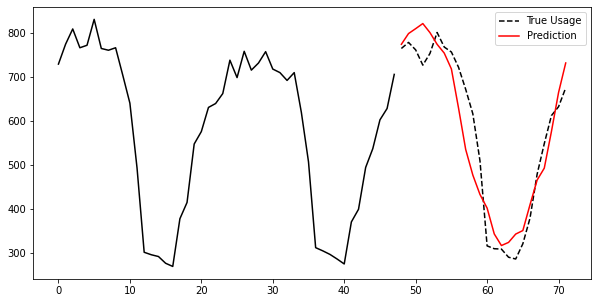

In [43]:
plot_predictions(X, Y, Y_hat, 28)

In [44]:
def compute_mape(Y_true, Y_pred, return_list = True):
    Y_true = np.exp(Y_true)
    Y_pred = np.exp(Y_pred) - 1
    Y_pred = Y_pred.clip(min = 0)
    
    abs_error = abs(Y_true - Y_pred)
    APE = abs_error/Y_true
    MAPE_customer = np.mean(APE, axis = 1)
    print('Overall model MAPE: {:.2%}'.format(np.mean(MAPE_customer)))
    print('Overall model MAPE (median): {:.2%}'.format(np.median(MAPE_customer)))
    return MAPE_customer
    

In [45]:
def plot_ranked(Y_true, Y_pred, X, mape, best = True, top = 5):
    sorted_mape = np.argsort(mape)
    if best:
        idx = sorted_mape[:top]
    else:
        idx = sorted_mape[-top:]
    for i in idx:
  
        plot_predictions(X, Y_true, Y_pred, i)
        plt.title("{:.2%}".format(mape[i]))
        plt.plot()

In [46]:
mape_list = compute_mape(Y, Y_hat)

Overall model MAPE: 21.49%
Overall model MAPE (median): 12.65%


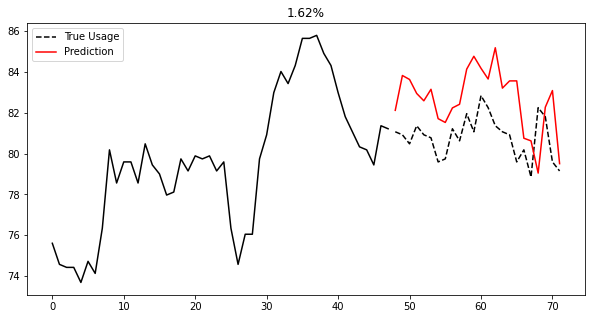

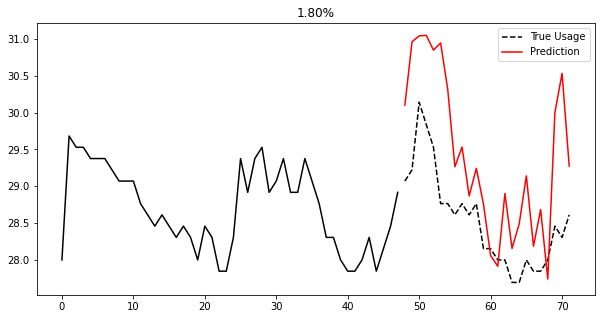

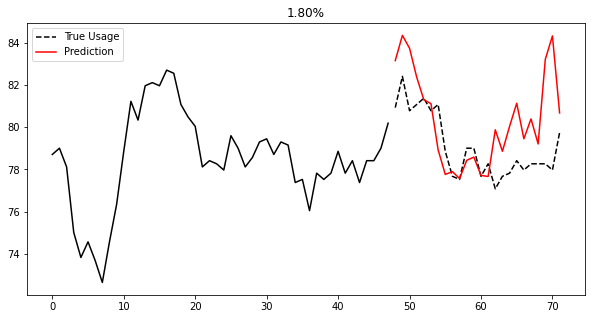

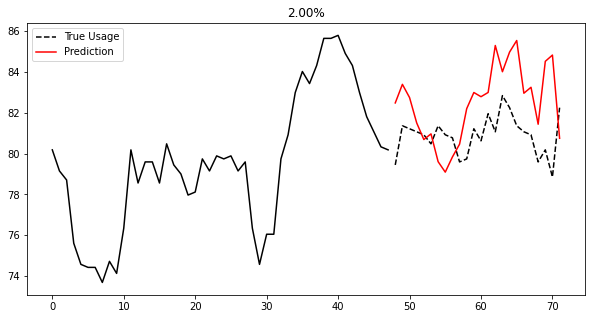

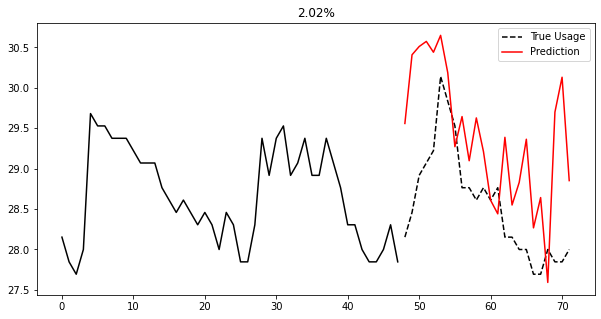

In [47]:
plot_ranked(Y, Y_hat, X, mape_list)

#plot_predictions(X, Y, Y_hat, 28)

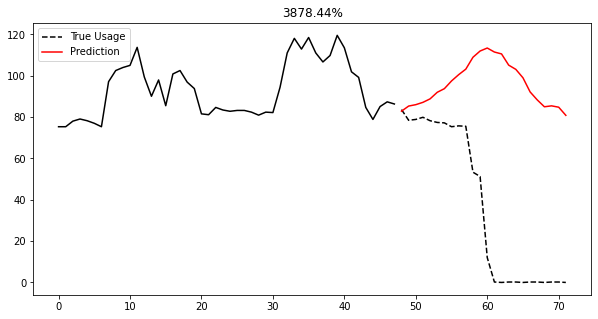

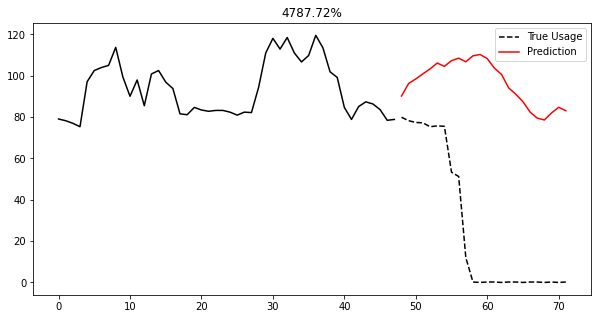

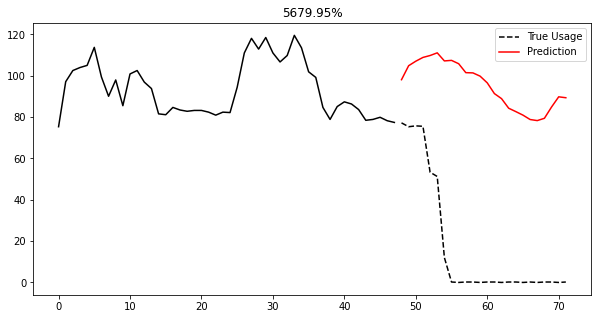

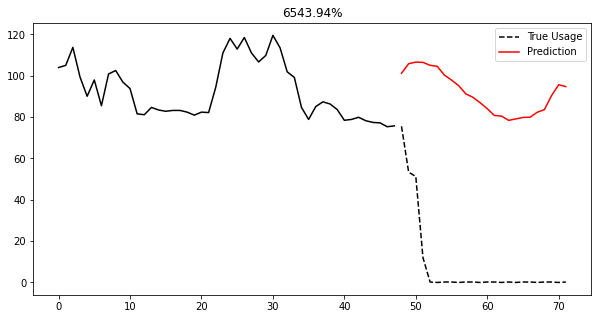

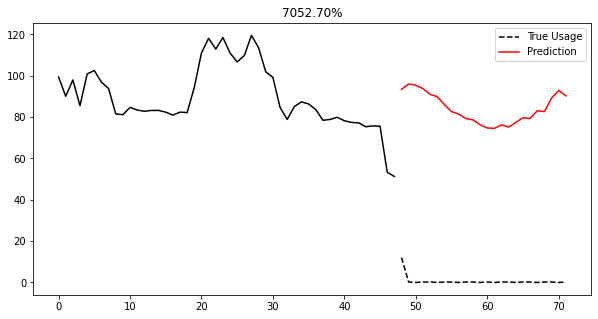

In [48]:
plot_ranked(Y, Y_hat, X, mape_list, best = False)

In [49]:
# cd URDeepLearning/Forecasting
# python3 -m tensorboard.main --logdir=training/arbitrary/random_dropout_0.05_20220509-173349
# http://localhost:6006/#scalars